 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/simple_network.ipynb#Set-up-Theano-class" data-toc-modified-id="Set-up-Theano-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set up Theano class</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/simple_network.ipynb#Sample-prediction-for-one-day" data-toc-modified-id="Sample-prediction-for-one-day-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sample prediction for one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/simple_network.ipynb#Test-for-period" data-toc-modified-id="Test-for-period-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Test for period</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/simple_network.ipynb#Run-the-full-experiment" data-toc-modified-id="Run-the-full-experiment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run the full experiment</a></span></li><li><span><a href="http://localhost:8888/notebooks/simple_network.ipynb#Build-a-fully-connected-Keras-model" data-toc-modified-id="Build-a-fully-connected-Keras-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build a fully connected Keras model</a></span></li></ul></div>

# Simple network to minimize CRPS


The EMOS analog is a simple network like this:

![title](EMOS_network.png)

In this notebook we will build this simple network in theano and use the CRPS as a cost function. 

In [1]:
# First, let's import the libraries we need
import theano
import theano.tensor as T
import numpy as np
from importlib import reload   # So that we can reload utils
import utils; reload(utils)   # This contains our own functions
from utils import *

# Let's make this notebook reproducible by defining the random seed
np.random.RandomState(42)   # I don't even like the hitchhiker...

I followed this tutorial to figure out the theano basics: http://www.marekrei.com/blog/theano-tutorial/

We will now attempt to build a simplle class for our model following: https://github.com/marekrei/theano-tutorial/blob/master/classifier.py

So the first step is to create a class and initialize the network architecture. theano allocates a graph. This means that we first plot out the computations which will be done in the future. 

## Set up Theano class

In [2]:
class EMOS_Network(object):
    def __init__(self):
        """
        This function is called once an object of this class is created.
        """
        # Before we start with the network, let's define
        # the learning rate as an input so we can vary it
        lr = T.fscalar('lr')
        
        # First let's define the input to the network
        # This is the ensemble mean (meanx), 
        # the ensemble stadnard deviation (stdx) and
        # the corresponding observation (target)
        # In theano we use tensors to describe these variables.
        # T.fvector allocates a float32 1D vector
        meanx = T.fvector('meanx')   # The name helps with debugging
        stdx = T.fvector('stdx')
        target = T.fvector('target')
        
        # Next we allocate the weights (a, b, c, d) as shared
        # variables and initialize some value for them.
        # For now we will just draw a random variable from N(0, 1)
        a = theano.shared(np.random.randn(), 'a')
        b = theano.shared(np.random.randn(), 'b')
        c = theano.shared(np.random.randn(), 'c')
        d = theano.shared(np.random.randn(), 'd')
        
        # Now that we have the input and the weights, 
        # we can set up the network.
        mu = a + meanx * b
        sigma = c + stdx * d
        
        # Now comes the cost function.
        # To stop sigma from becoming negative we first have to 
        # convert it the the variance and then take the square
        # root again. (I learned from experience...)
        # This part of the code is inspired by Kai Polsterer's code!
        var = T.sqr(sigma)
        # The following three variables are just for convenience
        loc = (target - mu) / T.sqrt(var)
        phi = 1.0 / np.sqrt(2.0 * np.pi) * T.exp(-T.square(loc) / 2.0)
        Phi = 0.5 * (1.0 + T.erf(loc / np.sqrt(2.0)))
        # First we will compute the crps for each input/target pair
        crps =  T.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
        # Then we take the mean. The cost is now a scalar
        mean_crps = T.mean(crps)
        
        # Now compute the gradients of the cost function 
        # with respect to the four weights/parameters
        params = [a, b, c, d]   # Let's put them in a list for convenience
        gradients = theano.tensor.grad(mean_crps, params)
        
        # For gradient descent we now need to subtract the gradients
        # from our parameters to minimize the cost function
        # In theano we want to define a list of tuples containing
        # the old parameter and the updated parameter.
        updates = [(p, p - lr * g) for p, g in zip(params, gradients)]
        
        # So far no actual computations have been done. Now we will
        # define a Theano function, which takes input, does some 
        # calculations and returns some output. In our case, we use 
        # meanx, stdx and the target as an input plus the required 
        # learning rate and return the mean_crps
        # as an output. Then we tell the function to apply the update
        # every time it is called. This is the training
        self.train = theano.function([meanx, stdx, target, lr], 
                                     mean_crps, updates=updates)
        # Furthermore, we define a method for simply making a prediction
        # and returning the predicted values of mu and sigma
        # along with the mean_crps without updating the parameters
        self.predict = theano.function([meanx, stdx, target],
                                       [mu, sigma, mean_crps])

### Sample prediction for one day
Now let's make a sample prediction for one day. First we need to prepare the data.

In [3]:
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # At LMU
DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
fn = 'data_interpolated.nc'

In [4]:
# Let's load the full dataset for 00 UTC
tobs_full, tfc_full, dates = load_nc_data(DATA_DIR + fn, utc=0)

In [6]:
tfc_full.shape

(3653, 50, 537)

In [8]:
# Now let's load the data for a particular date
from datetime import datetime
# Let's pick a random date
date_idx = np.where(dates == datetime(2011, 2, 14, 0, 0))[0][0]

In [9]:
date_idx = 1507

In [10]:
# Now let's get the data with the handy function in utils
window_size = 50
fclt = 48
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            window_size, fclt)

In [11]:
# Now let's initialize the model
model = EMOS_Network()

In [12]:
# And train it
# Let's also implement early stopping
early_stopping_delta = 0.000001
lr = np.asarray(0.1, dtype='float32')
cost_list = [1e99] * 5
mean_cost_old = np.mean(cost_list[-5:])
for i in range(10000):
    cost = model.train(tfc_mean_train, tfc_std_train, tobs_train, lr)
    cost_list.append(cost)
    
    mean_cost = np.mean(cost_list[-5:])
    if mean_cost_old - mean_cost < early_stopping_delta:
        if verbose ==1: print('Stop training at step %i' % i)
        break
    
    mean_cost_old = mean_cost
    
    if i%50 == 0 and verbose == 1: 
        print('Step %i; mean_crps = %.3f' % (i, cost))

Step 0; mean_crps = 3.334
Step 50; mean_crps = 1.532
Step 100; mean_crps = 1.283
Step 150; mean_crps = 1.264
Step 200; mean_crps = 1.259
Step 250; mean_crps = 1.256
Step 300; mean_crps = 1.253
Step 350; mean_crps = 1.250
Step 400; mean_crps = 1.246
Step 450; mean_crps = 1.240
Step 500; mean_crps = 1.232
Step 550; mean_crps = 1.220
Step 600; mean_crps = 1.204
Step 650; mean_crps = 1.178
Step 700; mean_crps = 1.171
Step 750; mean_crps = 1.170
Step 800; mean_crps = 1.169
Step 850; mean_crps = 1.169
Stop training at step 900


So the early stopping check whether the average of the last 5 training crps's still decreases. I think it's better to do this with a validation set, but we don't have one for now. For our simple network, this should be enough. 

In [13]:
model.predict(tfc_mean_test, tfc_std_test, tobs_test)[2]

array(1.0251625721652435)

In [14]:
# Let's compare that to the skill of the raw ensemble
# Now rememeber tfc_mean_test and tfc_std_test are scaled,
# so they are not compatible to tobs
# So let's load the not-scaled (ns) data
tobs_test, tfc_mean_test_ns, tfc_std_test_ns = prep_data(tobs_full[date_idx],
                                                         tfc_full[date_idx])
crps_normal(tfc_mean_test_ns, tfc_std_test_ns, tobs_test).mean()

1.1118336874995853

So a definite improvement! Let's now set up a loop to go through the period. Then let's check what takes time and maybe try running this on GPU!

### Test for period

In [229]:
# Let's define the period to loop over
# For testing purposes let's do 5 days
from datetime import datetime
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2008, 1, 31, 0, 0))[0][0]

In [230]:
# Loop
import timeit
crps_train_list = []
crps_test_list = []
lr = np.asarray(0.1, dtype='float32')
window_size = 50
nb_steps_max = 2000   # This is the maximum number of steps

early_stopping_delta = 0.000001


# Start timer
time_start = timeit.default_timer()
time_model = 0
time_train = 0
time_test = 0
time_data = 0

# Let's only initialize the model once, and then always update the weights
t1 = timeit.default_timer()
model = EMOS_Network()
t2 = timeit.default_timer()
time_model += t2 - t1

for date_idx in range(date_idx_start, date_idx_stop + 1):
    print(dates[date_idx])
    # Get the data
    t1 = timeit.default_timer()
    tfc_mean_train, tfc_std_train, tobs_train, \
        tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            window_size, fclt)
    t2 = timeit.default_timer()
    time_data += t2 - t1
    
    # Train the model 
    t1 = timeit.default_timer()
    cost_list = [1e99] * 5
    mean_cost_old = np.mean(cost_list[-5:])
    for i in range(nb_steps_max):
        cost = model.train(tfc_mean_train, tfc_std_train, tobs_train, lr)
        cost_list.append(cost)
        mean_cost = np.mean(cost_list[-5:])
        if mean_cost_old - mean_cost < early_stopping_delta:
            print('Stop training at step %i' % i)
            break
        mean_cost_old = mean_cost
    crps_train_list.append(cost)
    
    t2 = timeit.default_timer()
    time_train += t2 - t1

    # Now let's compute the CRPS of the test data
    t1 = timeit.default_timer()
    crps_pred = model.predict(tfc_mean_test, tfc_std_test, tobs_test)[2]
    crps_test_list.append(crps_pred)
    t2 = timeit.default_timer()
    time_test += t2 - t1

# Stop timer and print time
time_stop = timeit.default_timer()
print('Time: %.2f s' % (time_stop - time_start))
print(time_data)
print(time_model)
print(time_train)
print(time_test)

2008-01-01 00:00:00
Stop training at step 964
2008-01-02 00:00:00
Stop training at step 32
2008-01-03 00:00:00
Stop training at step 42
2008-01-04 00:00:00
Stop training at step 54
2008-01-05 00:00:00
Stop training at step 74
2008-01-06 00:00:00
Stop training at step 73
2008-01-07 00:00:00
Stop training at step 66
2008-01-08 00:00:00
Stop training at step 15
2008-01-09 00:00:00
Stop training at step 55
2008-01-10 00:00:00
Stop training at step 33
2008-01-11 00:00:00
Stop training at step 61
2008-01-12 00:00:00
Stop training at step 15
2008-01-13 00:00:00
Stop training at step 45
2008-01-14 00:00:00
Stop training at step 54
2008-01-15 00:00:00
Stop training at step 38
2008-01-16 00:00:00
Stop training at step 33
2008-01-17 00:00:00
Stop training at step 36
2008-01-18 00:00:00
Stop training at step 38
2008-01-19 00:00:00
Stop training at step 73
2008-01-20 00:00:00
Stop training at step 71
2008-01-21 00:00:00
Stop training at step 75
2008-01-22 00:00:00
Stop training at step 83
2008-01-2

So with the early stopping and not reinitializing the model every step we can drastically reduce the training time. But let's check whether this actually gives the same results.

## Run the full experiment

In [254]:
def run_experiment(date_idx_start, date_idx_stop, tobs_full, tfc_full,
                   nb_steps_max, window_size, early_stopping_delta=None,
                   lr=0.1, reinit_model=False):
    """
    Function to run a the network for the required period.
    """
    
    crps_train_list = []
    crps_test_list = []
    lr = np.asarray(lr, dtype='float32')
    window_size = 50
    nb_steps_max = 2000   # This is the maximum number of steps
    
    # Set up model
    model = EMOS_Network()
    
    # Start timer and loop
    time_start = timeit.default_timer()
    for date_idx in range(date_idx_start, date_idx_stop + 1):
        if dates[date_idx].day == 1:
            print(dates[date_idx])
        # Get the data
        tfc_mean_train, tfc_std_train, tobs_train, \
            tfc_mean_test, tfc_std_test, tobs_test = \
            get_train_test_data(tobs_full, tfc_full, date_idx, 
                                window_size, fclt)
        
        # Reinitialize model if requested
        if reinit_model:
            model = EMOS_Network()
        
        # Train the model 
        tmp_cost_list = [1e99] * 5   # Start with a really high cost
        mean_cost_old = np.mean(tmp_cost_list[-5:])
        for i in range(nb_steps_max):
            cost = model.train(tfc_mean_train, tfc_std_train, 
                               tobs_train, lr)
            
            # Check for early stopping if requested
            if early_stopping_delta is not None:
                tmp_cost_list.append(cost)
                mean_cost = np.mean(tmp_cost_list[-5:])
                if mean_cost_old - mean_cost < early_stopping_delta:
                    break
                mean_cost_old = mean_cost
                
        crps_train_list.append(cost)

        # Now let's compute the CRPS of the test data
        crps_pred = model.predict(tfc_mean_test, tfc_std_test, 
                                  tobs_test)[2]
        crps_test_list.append(crps_pred)

    # Stop timer and print time
    time_stop = timeit.default_timer()
    print('Time: %.2f s' % (time_stop - time_start))
    
    return crps_train_list, crps_test_list

In [240]:
# Set up first experiment with model reinitialization and no early stopping
# With 500 steps 
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2008, 1, 31, 0, 0))[0][0]
r = run_experiment(date_idx_start, date_idx_stop, tobs_full, tfc_full,
                   500, 50, early_stopping_delta=None,
                   lr=0.1, reinit_model=True)

2008-01-01 00:00:00
Time: 261.38 s


In [250]:
# Now do the same without model reinitialization and with early stopping
r2 = run_experiment(date_idx_start, date_idx_stop, tobs_full, tfc_full,
                    2000, 50, early_stopping_delta=0.000001,
                    lr=0.1, reinit_model=False)

Time: 10.59 s


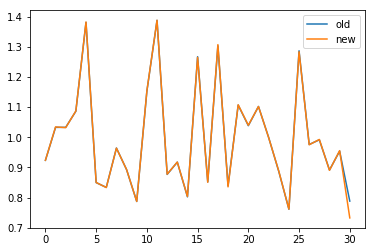

In [251]:
# Let's compare the results
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(r[1], label = 'old')
plt.plot(r2[1], label = 'new')
plt.legend()
plt.show()

Ok, let's note down that the training for one month with early stopping and reusing the model took around 10s on my Mac.

In [255]:
# now let's train for the entire period
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2016, 12, 31, 0, 0))[0][0]

In [269]:
r = run_experiment(date_idx_start, date_idx_stop, tobs_full, tfc_full,
                    2000, 25, early_stopping_delta=0.000001,
                    lr=0.1, reinit_model=False)

2008-01-01 00:00:00
2008-02-01 00:00:00
2008-03-01 00:00:00
2008-04-01 00:00:00
2008-05-01 00:00:00
2008-06-01 00:00:00
2008-07-01 00:00:00
2008-08-01 00:00:00
2008-09-01 00:00:00
2008-10-01 00:00:00
2008-11-01 00:00:00
2008-12-01 00:00:00
2009-01-01 00:00:00
2009-02-01 00:00:00
2009-03-01 00:00:00
2009-04-01 00:00:00
2009-05-01 00:00:00
2009-06-01 00:00:00
2009-07-01 00:00:00
2009-08-01 00:00:00
2009-09-01 00:00:00
2009-10-01 00:00:00
2009-11-01 00:00:00
2009-12-01 00:00:00
2010-01-01 00:00:00
2010-02-01 00:00:00
2010-03-01 00:00:00
2010-04-01 00:00:00
2010-05-01 00:00:00
2010-06-01 00:00:00
2010-07-01 00:00:00
2010-08-01 00:00:00
2010-09-01 00:00:00
2010-10-01 00:00:00
2010-11-01 00:00:00
2010-12-01 00:00:00
2011-01-01 00:00:00
2011-02-01 00:00:00
2011-03-01 00:00:00
2011-04-01 00:00:00
2011-05-01 00:00:00
2011-06-01 00:00:00
2011-07-01 00:00:00
2011-08-01 00:00:00
2011-09-01 00:00:00
2011-10-01 00:00:00
2011-11-01 00:00:00
2011-12-01 00:00:00
2012-01-01 00:00:00
2012-02-01 00:00:00


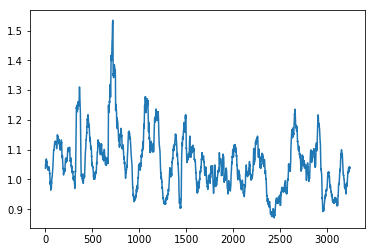

In [270]:
# Plot the results
crps_test = np.array(r[1])

# Get 50 day rolling mean
crps_smooth = np.convolve(crps_test, np.ones(50) / 50., 'valid')
plt.plot(crps_smooth)

In [271]:
months = np.array([d.month for d in list(dates[date_idx_start:date_idx_stop])])
months.shape

(3287,)

In [272]:
# get monthly mean
monthly_mean_crps = np.zeros(12)
for i in range(1, 13):
    monthly_mean_crps[i-1] = np.mean(crps_test[months == i])

/Users/stephanrasp/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3288 but corresponding boolean dimension is 3287
  after removing the cwd from sys.path.


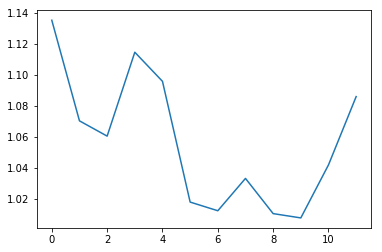

In [273]:
plt.plot(monthly_mean_crps)

Ok, so we get basically the same results as with standard EMOS. First checkpoint reached. Some ideas for what to do next:

- Do a local EMOS (but that probably just gives the same results again...)
- Make the network fully connected and implement in keras (for simplicity) and see whether that actually changes anything.
- Add other variables at the station (altitude is available, but then looking at the TIGGE data I can think of land-sea mask (with a CCN at some point), surface pressure, precipitation, wind at some altitude, relative humidity)
- then the first step could be just extending the network with the means of all the extra predictors and maybe adding some hidden layers. (For all this keras would be immensly useful!)

## Build a fully connected Keras model

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.optimizers import Adam
import tensorflow as tf

In [39]:
# Define the CRPS cost function
def crps_loss(y_true, y_pred):
    # Split into means and sigmas
    mean = y_pred[:, 0]
    sigma = y_pred[:, 1]
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mean) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    mean_crps = K.mean(crps)
    return mean_crps

In [27]:
tfc_mean_train.shape

(25190,)

In [28]:
tfc_std_train.shape

(25190,)

In [29]:
in_train = np.column_stack([tfc_mean_train, tfc_std_train])
in_train.shape

(25190, 2)

In [40]:
model_fc = Sequential([
    Dense(2, input_shape=(2,), activation='linear')
])

In [41]:
opt = Adam(lr=1e-2)
model_fc.compile(optimizer=opt, loss=crps_loss, metrics=[crps_loss])

In [ ]:
model_fc.fit(in_train, tobs_train, epochs=1, batch_size=25190, verbose=0)